# Homework 7: Problems

### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018/blob/master/homework/HW7.ipynb

## Problem: use KDE to make Hess-like diagrams

Use Kernel Density Estimation (KDE) with a top-hat, Gaussian, and exponential 
kernel to analyze 4-D data for variable stars from the SDSS and LINEAR surveys:
-- SDSS u-g and g-i colors,
-- LINEAR variability period (logP) and variability amplitude (A), that
you already encountered in Homework 6. Please produce the g-i vs. u-g, and 
A vs. logP, diagrams for each of the three kernels above (that is, make the 
analogs of Figure 6.3 from the textbook). Experiment with different kernel 
bandwidths, plotting one that visually seems "best" (i.e., a good balance of 
bias vs. variance) for each kernel.

Please change the original figure size (i.e. the size of Figure 6.3) so that 
individual panels in your solution have aspect ratios closer to what is common 
for color-magnitude diagrams (i.e., x:y $\approx$ 4:6 or so).






<br>
# Homework 7: Solutions

### Some useful definitions and functions

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from astroML.density_estimation import KDE
from astroML.datasets import fetch_LINEAR_geneva
from matplotlib.colors import LogNorm, Normalize

from matplotlib.colors import LogNorm, Normalize
from scipy.stats import norm
from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import KernelDensity

from astroML.datasets import fetch_great_wall
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

## Problem 1
First obtain LINEAR data for 6,146 stars using astroML built-in function: 

In [2]:
data = fetch_LINEAR_geneva()
# N.B. this is a 7-dimensional dataset
ug = data['ug']
gi = data['gi']
logP = data['logP']
A = data['amp']
# will need for GMM clustering analysis
X = np.vstack([ug,gi]).T
Y = np.vstack([logP,A]).T

In [3]:
N = len(ug)


and plot a few diagrams just to make sure that data are fine...

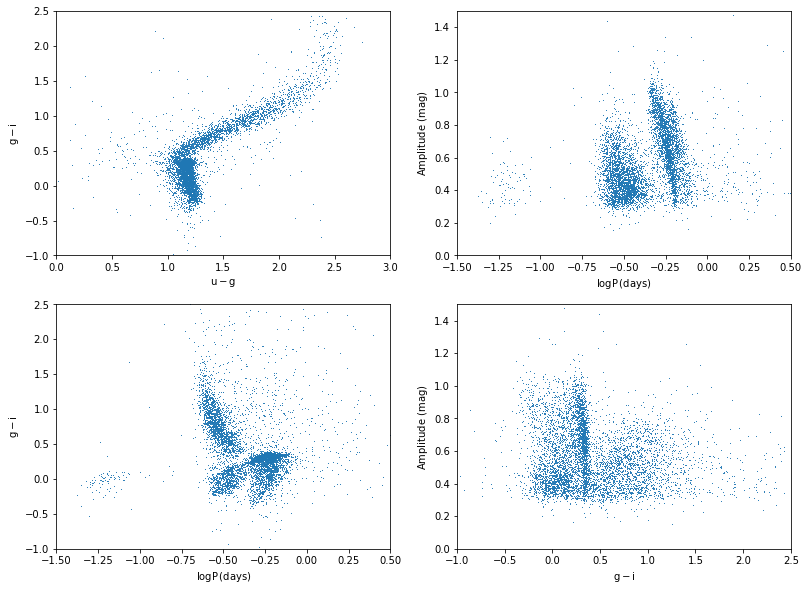

In [4]:
# set up the plot
fig = plt.figure(figsize=(12, 9), facecolor='w')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2, bottom=0.1, top=0.93)

# plot the color-color plot
ax1 = fig.add_subplot(221)
ax1.scatter(ug, gi, s=0.9, lw=0)
ax1.set_xlim(0.0, 3.0)
ax1.set_ylim(-1.0, 2.5)
ax1.set_xlabel(r'${\rm u-g}$', color='k')
ax1.set_ylabel(r'${\rm g-i}$', color='k')

# plot the A vs. logP plot
ax2 = fig.add_subplot(222)
ax2.scatter(logP, A, s=0.9, lw=0)
ax2.set_xlim(-1.5, 0.5)
ax2.set_ylim(0.0, 1.5)
ax2.set_xlabel(r'${\rm logP \, (days)}$', color='k')
ax2.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='k')

# g-i vs. logP
ax3 = fig.add_subplot(223)
ax3.scatter(logP, gi, s=0.9, lw=0)
ax3.set_xlim(-1.5, 0.5)
ax3.set_ylim(-1.0, 2.5)
ax3.set_xlabel(r'${\rm logP \, (days)}$', color='k')
ax3.set_ylabel(r'${\rm g-i}$', color='k')

# A vs. g-i 
ax4 = fig.add_subplot(224)
ax4.scatter(gi, A, s=0.9, lw=0)
ax4.set_xlim(-1.0, 2.5)
ax4.set_ylim(0.0, 1.5)
ax4.set_xlabel(r'${\rm g-i}$', color='k')
ax4.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='k')

plt.show()

And then do the required KDE analysis...

In [5]:
quants = [ug,gi,logP,A]

In [6]:
xmin = [(quant).min() for quant in quants]
xmax = [(quant).max() for quant in quants]

In [7]:
print (xmin)
print (xmax)

[-2.2010000000000001, -1.9870000000000001, -1.3761823, -99.989999999999995]
[2.75, 3.6150000000000002, 1.5289999000000001, 1.651]


In [8]:
Nx = 100
Ny = 200

In [9]:
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin[0], xmax[0], Nx),
                                            np.linspace(xmin[1], xmax[1], Ny)))).T

In [29]:
kde1 = KDE(metric='gaussian', h=0.005)
dens1 = kde1.fit(X).eval(Xgrid).reshape((Ny, Nx))

kde2 = KDE(metric='tophat', h=0.030)
dens2 = kde2.fit(X).eval(Xgrid).reshape((Ny, Nx))

kde3 = KDE(metric='exponential', h=0.001)
dens3 = kde3.fit(X).eval(Xgrid).reshape((Ny, Nx))

/home/aish/anaconda3/lib/python3.6/site-packages/astroML/density_estimation/density_estimation.py:74: UserWarning: The KDE class is deprecated as of version 0.2 and will be removed in version 0.3. Upgrade to scikit-learn version >0.14 and use sklearn.neighbors.KernelDensity instead.
  warnings.warn("The KDE class is deprecated as of version 0.2 and will "


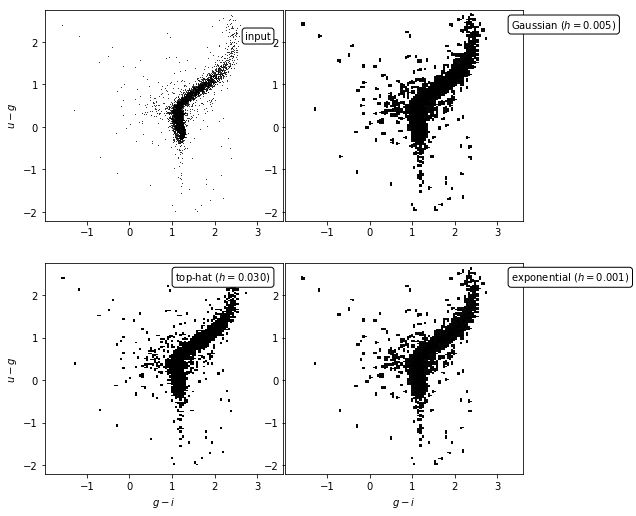

In [30]:
fig = plt.figure(figsize=(8,10))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 0], X[:, 1], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1, origin='lower', norm=LogNorm(),
           extent=(xmin[0], xmax[0], xmin[1], xmax[1]), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=0.005)$", ha='left', va='bottom',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2, origin='lower', norm=LogNorm(),
           extent=(xmin[0], xmax[0], xmin[1], xmax[1]), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "top-hat $(h=0.030)$", ha='right', va='bottom',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3, origin='lower', norm=LogNorm(),
           extent=(xmin[0], xmax[0], xmin[1], xmax[1]), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "exponential $(h=0.001)$", ha='left', va='bottom',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xmin[1], xmax[1] - 0.01)
    ax.set_ylim(xmin[0], xmax[0])
    
for ax in [ax3, ax4]:
    ax.set_xlabel('$g-i$')

for ax in [ax1, ax3]:
    ax.set_ylabel('$u-g$')
plt.show()

In [12]:
Ygrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin[2], xmax[2], Nx),
                                            np.linspace(0, xmax[3], Ny)))).T

In [18]:
kde4 = KDE(metric='gaussian', h=0.001)
dens4 = kde4.fit(Y).eval(Ygrid).reshape((Ny, Nx))

kde5 = KDE(metric='tophat', h=0.01)
dens5 = kde5.fit(Y).eval(Ygrid).reshape((Ny, Nx))

kde6 = KDE(metric='exponential', h=0.0001)
dens6 = kde6.fit(Y).eval(Ygrid).reshape((Ny, Nx))

/home/aish/anaconda3/lib/python3.6/site-packages/astroML/density_estimation/density_estimation.py:74: UserWarning: The KDE class is deprecated as of version 0.2 and will be removed in version 0.3. Upgrade to scikit-learn version >0.14 and use sklearn.neighbors.KernelDensity instead.
  warnings.warn("The KDE class is deprecated as of version 0.2 and will "


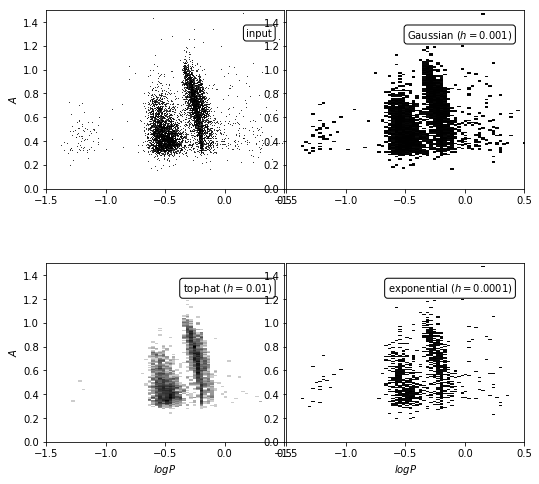

In [24]:
fig = plt.figure(figsize=(8,10))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(Y[:, 0], Y[:, 1], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens4, origin='lower', norm=LogNorm(),
           extent=(xmin[2], xmax[2], 0, xmax[3]), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=0.001)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens5, origin='lower', norm=LogNorm(),
           extent=(xmin[2], xmax[2], 0, xmax[3]), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "top-hat $(h=0.01)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens6, origin='lower', norm=LogNorm(),
           extent=(xmin[2], xmax[2], 0, xmax[3]), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "exponential $(h=0.0001)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(-1.5,0.5)
    ax.set_ylim(0, 1.5)
    
for ax in [ax3, ax4]:
    ax.set_xlabel('$logP$')

for ax in [ax1, ax3]:
    ax.set_ylabel('$A$')
plt.show()

***Comment:*** In my view, exponentiial KDE seems the sharpest.

Submitted on: 20.11.2018.